### Clustering on NBA dataset

In this session, we will perform clustering on the NBA dataset. The dataset is available at the following link: [NBA dataset](https://www.basketball-reference.com/leagues/NBA_2024_per_game.html).   

In [278]:
import pandas as pd
data = pd.read_csv('D:/学术/tweet/archive/csv/DBM2/Player_clustering.csv')
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 735
Number of attributes = 31


,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Player-additional
0,Joel Embiid,29,PHI,C,39,39,33.6,11.5,21.8,0.529,...,8.6,11.0,5.6,1.2,1.7,3.8,2.9,34.7,AS,embiijo01
1,Luka Dončić,24,DAL,PG,70,70,37.5,11.5,23.6,0.487,...,8.4,9.2,9.8,1.4,0.5,4.0,2.1,33.9,MVP-3CPOY-6ASNBA1,doncilu01
2,Giannis Antetokounmpo,29,MIL,PF,73,73,35.2,11.5,18.8,0.611,...,8.8,11.5,6.5,1.2,1.1,3.4,2.9,30.4,MVP-4DPOY-9CPOY-12ASNBA1,antetgi01
3,Shai Gilgeous-Alexander,25,OKC,PG,75,75,34.0,10.6,19.8,0.535,...,4.7,5.5,6.2,2.0,0.9,2.2,2.5,30.1,MVP-2DPOY-7CPOY-3ASNBA1,gilgesh01
4,Jalen Brunson,27,NYK,PG,77,77,35.4,10.3,21.4,0.479,...,3.1,3.6,6.7,0.9,0.2,2.4,1.9,28.7,MVP-5CPOY-5ASNBA2,brunsja01


### Step1 Data preprocessing
1.1 Delete some of the columns and rebundant insatances(Some players have multiple rows because they played for different teams in different times, we only keep one row for each player).

1.2 Delete the noisy data(players played less than certain minutes and games).

1.3 Combine the steal and block data into one column(reduce the dimension).

1.4 Standardize the data.

In [279]:
file_path = 'D:/学术/tweet/archive/csv/DBM2/Player_clustering.csv' 
df = pd.read_csv(file_path)

columns_to_keep = ['Player', 'G', 'MP', 'STL', 'BLK', 'PTS']
df_filtered = df[columns_to_keep]
df_unique = df_filtered.drop_duplicates(subset='Player', keep='first')

output_file_path = 'filtered_file.csv'  
df_unique.to_csv(output_file_path, index=False)
print(f"Filtered CSV file saved to {output_file_path}")
df_unique.head()

Filtered CSV file saved to filtered_file.csv


,Player,G,MP,STL,BLK,PTS
0,Joel Embiid,39,33.6,1.2,1.7,34.7
1,Luka Dončić,70,37.5,1.4,0.5,33.9
2,Giannis Antetokounmpo,73,35.2,1.2,1.1,30.4
3,Shai Gilgeous-Alexander,75,34.0,2.0,0.9,30.1
4,Jalen Brunson,77,35.4,0.9,0.2,28.7


#### Some players played less than 25% of average game played by the league and 25% average minutes played by the league, we delete these players.

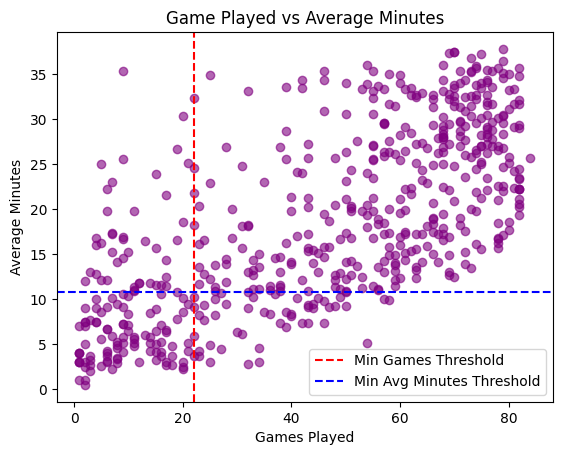

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns
file_path = 'D:/学术/tweet/archive/csv/DBM2/filtered_file.csv' 
df = pd.read_csv(file_path)
plt.scatter(df['G'], df['MP'], color='purple', alpha=0.6)
plt.title('Game Played vs Average Minutes')
plt.xlabel('Games Played')
plt.ylabel('Average Minutes')
games_threshold = df['G'].quantile(0.25)
minutes_threshold = df['MP'].quantile(0.25)
plt.axvline(x=games_threshold, color='red', linestyle='--', label='Min Games Threshold')  
plt.axhline(y=minutes_threshold, color='blue', linestyle='--', label='Min Avg Minutes Threshold')  
plt.legend()
plt.show()
filtered_df = df[(df['G'] >= games_threshold) & 
                 (df['MP'] >= minutes_threshold)]
output_file_path = 'filtered_file.csv'  
filtered_df.to_csv(output_file_path, index=False)



#### Combine the block column and steal column into a new column called defense_features. We also conveyed all the data into per 36 performance in order to make the data more comparable.

In [281]:
#Standerdization
from sklearn.preprocessing import StandardScaler
df= pd.read_csv('D:/学术/tweet/archive/csv/DBM2/filtered_file.csv')
df['avg36pts']=(df['PTS']/(df['MP']/36))
df['avg36blk']=(df['BLK']/(df['MP']/36))
df['avg36stl']=(df['STL']/(df['MP']/36))
df['defense_features']=df['avg36blk']+df['avg36stl']
df.head()

,Player,G,MP,STL,BLK,PTS,avg36pts,avg36blk,avg36stl,defense_features
0,Joel Embiid,39,33.6,1.2,1.7,34.7,37.178571,1.821429,1.285714,3.107143
1,Luka Dončić,70,37.5,1.4,0.5,33.9,32.544000,0.480000,1.344000,1.824000
2,Giannis Antetokounmpo,73,35.2,1.2,1.1,30.4,31.090909,1.125000,1.227273,2.352273
3,Shai Gilgeous-Alexander,75,34.0,2.0,0.9,30.1,31.870588,0.952941,2.117647,3.070588
4,Jalen Brunson,77,35.4,0.9,0.2,28.7,29.186441,0.203390,0.915254,1.118644


#### As the data is not normalized(Points are way higher than blocks and steals, which will affect the results of the clustering), we need to standardize the data before clustering.

In [282]:
scaler = StandardScaler()
columns_to_standardize = ['avg36pts', 'defense_features']
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
df.to_csv('D:/学术/tweet/archive/csv/DBM2/filtered_file2.csv', index=False)
df.head()

,Player,G,MP,STL,BLK,PTS,avg36pts,avg36blk,avg36stl,defense_features
0,Joel Embiid,39,33.6,1.2,1.7,34.7,4.111973,1.821429,1.285714,1.600756
1,Luka Dončić,70,37.5,1.4,0.5,33.9,3.218483,0.480000,1.344000,-0.106250
2,Giannis Antetokounmpo,73,35.2,1.2,1.1,30.4,2.938344,1.125000,1.227273,0.596528
3,Shai Gilgeous-Alexander,75,34.0,2.0,0.9,30.1,3.088657,0.952941,2.117647,1.552126
4,Jalen Brunson,77,35.4,0.9,0.2,28.7,2.571185,0.203390,0.915254,-1.044608


### Step2 : Clustering


2.1 K-means :In this session, we will use the K-Means algorithm to cluster the data. And use elbow method and silhouette method to find the optimal number of clusters.

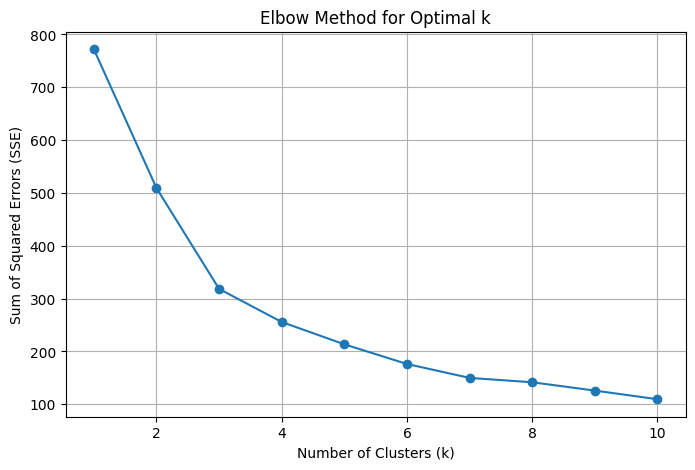

In [283]:
#Using Elbow Method to determine optimal number of clusters
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
features = df[['avg36pts', 'defense_features']]
sse = []
k_values = range(1, 11)  
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)  
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

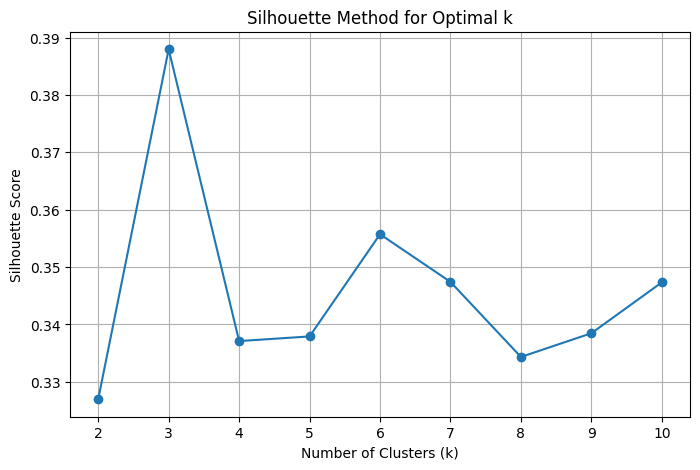

In [284]:
#Using silhouette method to find optimal number of clusters
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)
    score = silhouette_score(features, labels)
    silhouette_scores.append(score)
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid()
plt.show()


In [285]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

fig = px.scatter(
    df,
    x='avg36pts',
    y='defense_features',
    color=df['Cluster'].astype(str),
    hover_data={
        'Player': True, 
        'avg36pts': True,  
        'defense_features': True,  
        'Cluster': True,  
    },
    title='K-Means Clustering of Players',
    labels={'avg36pts': 'Avg Points per 36 Minutes', 'defense_features': 'Defensive Feature', 'Cluster': 'Cluster'}
)

centroids = kmeans.cluster_centers_
for i, (x, y) in enumerate(centroids):
    fig.add_scatter(
        x=[x], y=[y], mode='markers+text', 
        marker=dict(size=10, color='red'),
        text=[f'Centroid {i}'], textposition='top center', name='Centroids'
    )


fig.update_layout(
    xaxis=dict(scaleanchor="y", title='Avg Points per 36 Minutes'),
    yaxis=dict(title='Defensive Feature'),
    width=600,  
    height=600 
)
fig.show()

In [286]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

fig = px.scatter(
    df,
    x='avg36pts',
    y='defense_features',
    color=df['Cluster'].astype(str),
    hover_data={
        'Player': True, 
        'avg36pts': True,  
        'defense_features': True,  
        'Cluster': True,  
    },
    title='K-Means Clustering of Players',
    labels={'avg36pts': 'Avg Points per 36 Minutes', 'defense_features': 'Defensive Feature', 'Cluster': 'Cluster'}
)

centroids = kmeans.cluster_centers_
for i, (x, y) in enumerate(centroids):
    fig.add_scatter(
        x=[x], y=[y], mode='markers+text', 
        marker=dict(size=10, color='red'),
        text=[f'Centroid {i}'], textposition='top center', name='Centroids'
    )


fig.update_layout(
    xaxis=dict(scaleanchor="y", title='Avg Points per 36 Minutes'),
    yaxis=dict(title='Defensive Feature'),
    width=600, 
    height=600  
)
fig.show()

2.2 DBscan method

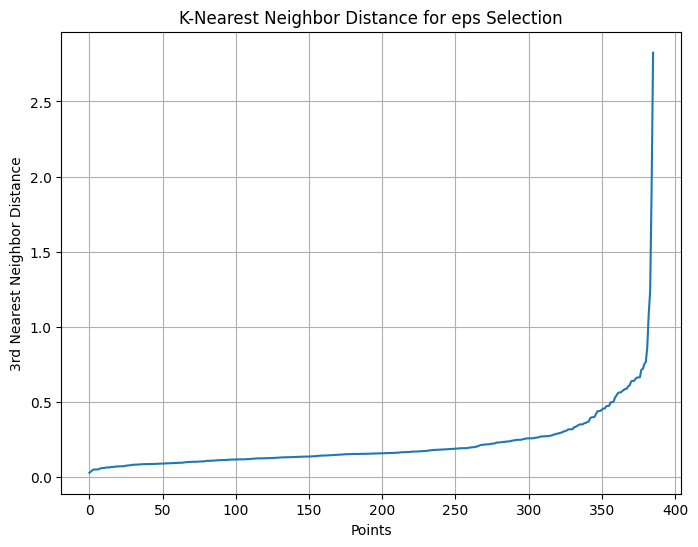

In [231]:
#Find proper epsillon by using k-neighbour algorithm.
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=4)  
neighbors_fit = neighbors.fit(features)
distances, indices = neighbors_fit.kneighbors(features)


distances = np.sort(distances[:, 3])  
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('3rd Nearest Neighbor Distance')
plt.title('K-Nearest Neighbor Distance for eps Selection')
plt.grid()
plt.show()


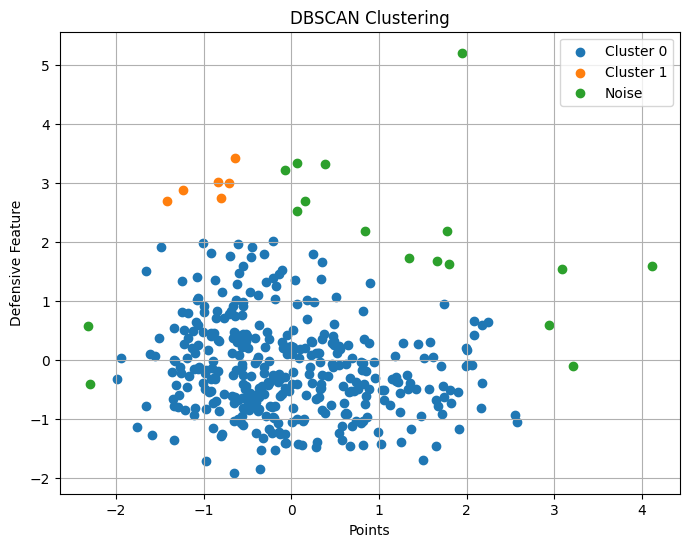

In [233]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=4)
df['Cluster'] = dbscan.fit_predict(features)

plt.figure(figsize=(8, 6))
unique_clusters = set(df['Cluster'])

for cluster in unique_clusters:
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['avg36pts'], cluster_data['defense_features'], label=f'Cluster {cluster}' if cluster != -1 else 'Noise')

plt.xlabel('Points')
plt.ylabel('Defensive Feature')
plt.title('DBSCAN Clustering')
plt.legend()
plt.grid()
plt.show()

2.3 Hierarchical Clustering

In this section, we will discuss the hierarchical clustering method. We used single link, complete link average and ward link.

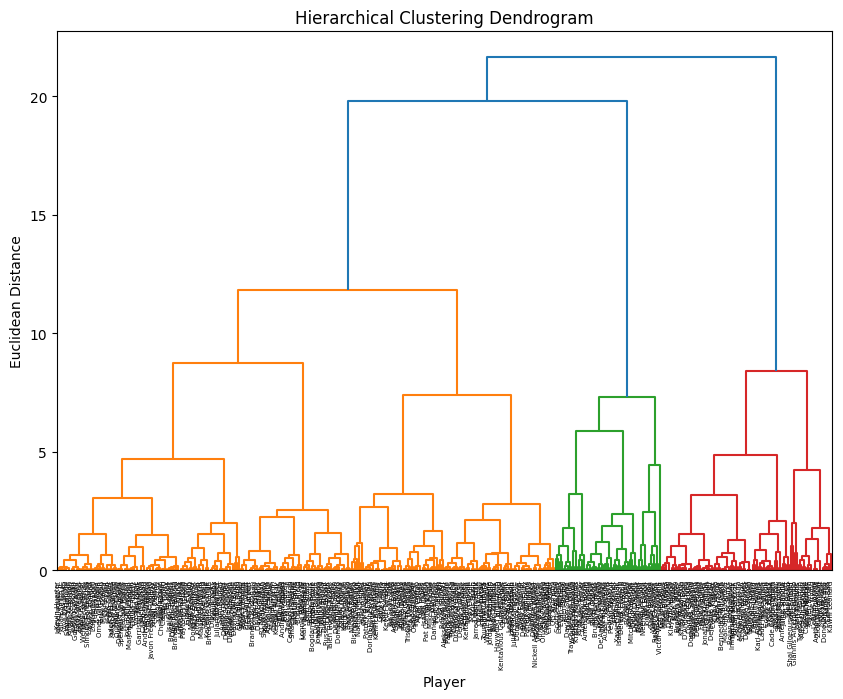

Silhouette Score: 0.379


In [256]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
linked = linkage(features, method='ward')  

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df['Player'].values, orientation='top', distance_sort='descending')
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('Player')
plt.ylabel('Euclidean Distance')
plt.show()
cluster = AgglomerativeClustering(n_clusters=3,  linkage='ward')
df['Cluster'] = cluster.fit_predict(features)
score = silhouette_score(features, df['Cluster'])
print(f'Silhouette Score: {score:.3f}')

In [257]:
fig = px.scatter(
    df,
    x='avg36pts',
    y='defense_features',
    color='Cluster',  
    hover_data={'Player': True, 'avg36pts': True, 'defense_features': True, 'Cluster': True},
    title='Hierarchical Clustering of Players',
    labels={'avg36pts': 'Avg Points per 36 Minutes', 'defense_features': 'Defensive Feature'}
)


fig.show()

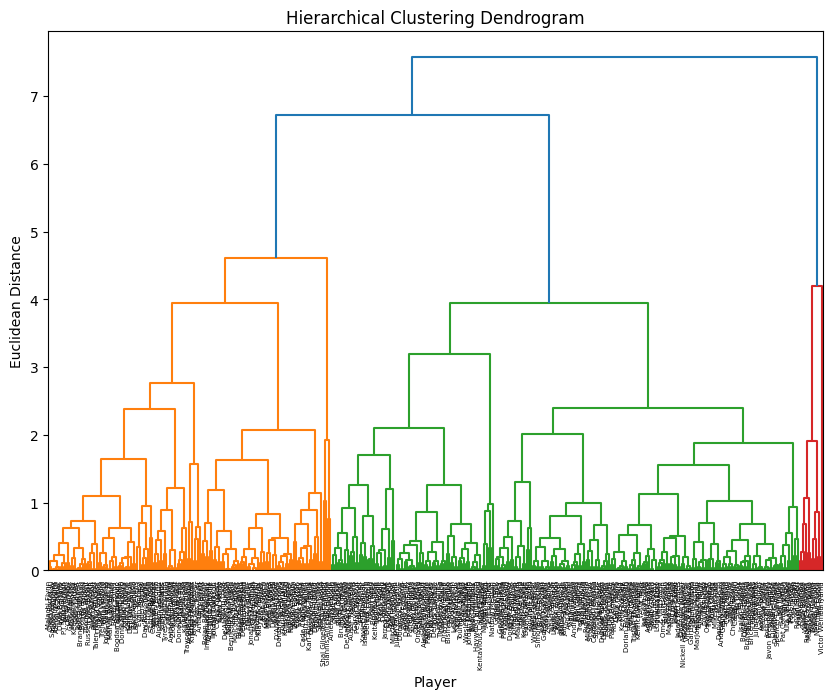

Silhouette Score: 0.331


In [264]:
linked = linkage(features, method='complete')  

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df['Player'].values, orientation='top', distance_sort='descending')
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('Player')
plt.ylabel('Euclidean Distance')
plt.show()
cluster = AgglomerativeClustering(n_clusters=3,  linkage='complete')
df['Cluster'] = cluster.fit_predict(features)
score = silhouette_score(features, df['Cluster'])
print(f'Silhouette Score: {score:.3f}')

In [265]:
fig = px.scatter(
    df,
    x='avg36pts',
    y='defense_features',
    color='Cluster',  
    hover_data={'Player': True, 'avg36pts': True, 'defense_features': True, 'Cluster': True},
    title='Hierarchical Clustering of Players',
    labels={'avg36pts': 'Avg Points per 36 Minutes', 'defense_features': 'Defensive Feature'}
)


fig.show()

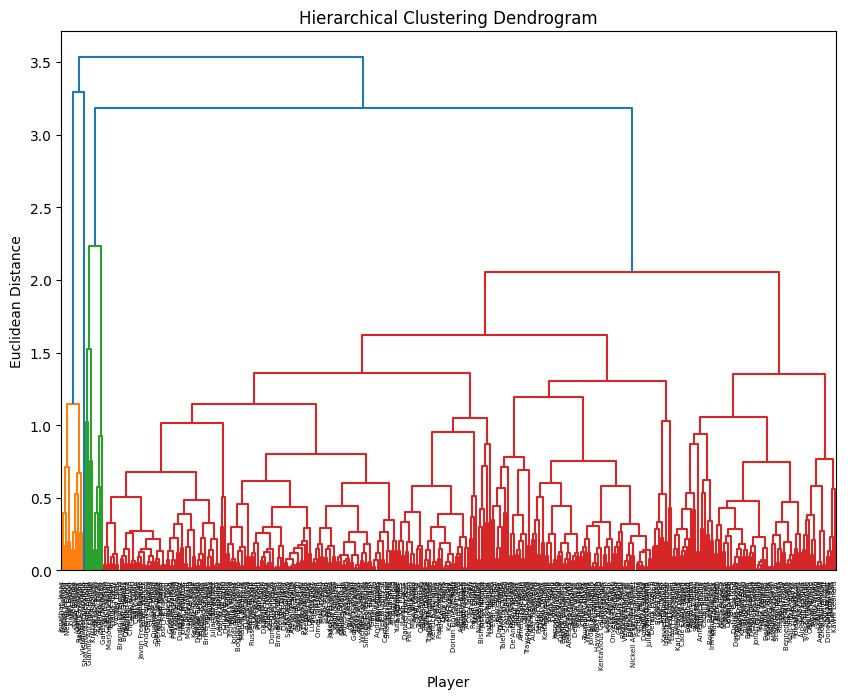

Silhouette Score: 0.483


In [274]:
linked = linkage(features, method='average')  

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df['Player'].values, orientation='top', distance_sort='descending')
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('Player')
plt.ylabel('Euclidean Distance')
plt.show()
cluster = AgglomerativeClustering(n_clusters=3,  linkage='average')
df['Cluster'] = cluster.fit_predict(features)
score = silhouette_score(features, df['Cluster'])
print(f'Silhouette Score: {score:.3f}')

In [275]:
fig = px.scatter(
    df,
    x='avg36pts',
    y='defense_features',
    color='Cluster',  
    hover_data={'Player': True, 'avg36pts': True, 'defense_features': True, 'Cluster': True},
    title='Hierarchical Clustering of Players',
    labels={'avg36pts': 'Avg Points per 36 Minutes', 'defense_features': 'Defensive Feature'}
)


fig.show()

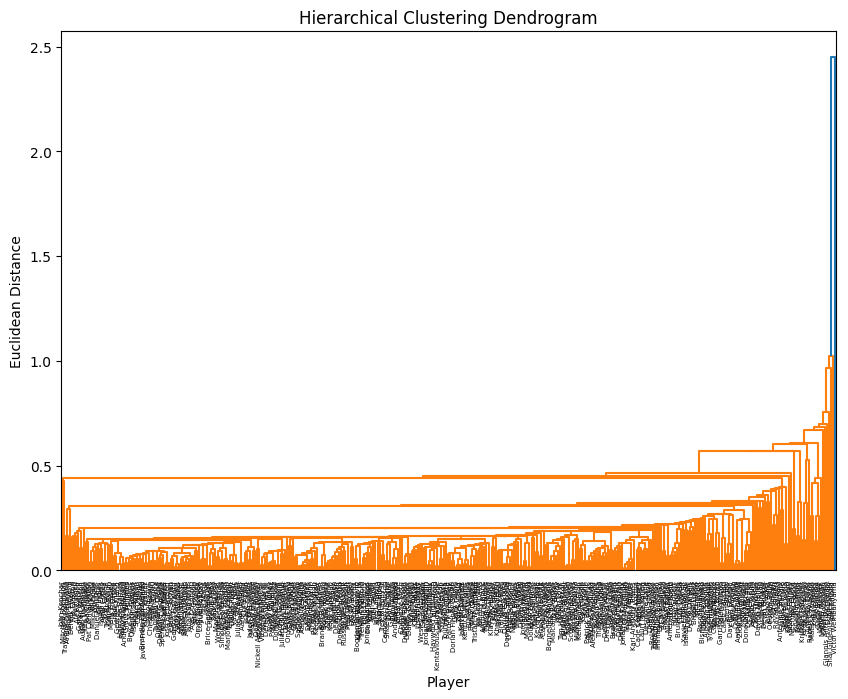

Silhouette Score: 0.587


In [276]:
linked = linkage(features, method='single')  

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=df['Player'].values, orientation='top', distance_sort='descending')
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('Player')
plt.ylabel('Euclidean Distance')
plt.show()
cluster = AgglomerativeClustering(n_clusters=3,  linkage='single')
df['Cluster'] = cluster.fit_predict(features)
score = silhouette_score(features, df['Cluster'])
print(f'Silhouette Score: {score:.3f}')

In [277]:
fig = px.scatter(
    df,
    x='avg36pts',
    y='defense_features',
    color='Cluster',  
    hover_data={'Player': True, 'avg36pts': True, 'defense_features': True, 'Cluster': True},
    title='Hierarchical Clustering of Players',
    labels={'avg36pts': 'Avg Points per 36 Minutes', 'defense_features': 'Defensive Feature'}
)


fig.show()